In [64]:
l_index = 16
layer_id = 'bn'

In [33]:
# -*- coding: utf-8 -*-
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
         #(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [36]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [32, 32, 'M', 64, 64, 'M', 128, 128, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif x == 'D2':
                layers += [nn.Dropout(p=0.2)]
            elif x == 'D3':
                layers += [nn.Dropout(p=0.3)]
            elif x == 'D4':
                layers += [nn.Dropout(p=0.4)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [38]:
net = VGG('VGG13').to(device)
criterion = nn.CrossEntropyLoss()

In [39]:
def cal_acc(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %.4f %%' % (
        100 * correct / total))

In [40]:
def cal_acc_train(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50000 train images: %d %%' % (
        100 * correct / total))

In [41]:
def cal_mass(net, l_index):
    num_iter = 0
    r = 0.0
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
            num_iter += 1
            if(num_iter == 40):
                break
            inputs, labels = data[0].to(device), data[1].to(device)
            L_self = 0.0
            L_mat = 0.0

            for epoch_num in range(1):
                out_features = net.features[0:l_index](inputs)
                X_t = out_features.reshape(out_features.shape[0], out_features.shape[1], -1)
                X_t = torch.div(X_t, X_t.norm(dim=2).reshape(X_t.shape[0],X_t.shape[1],1) + 1e-10)
                cov_mat = torch.matmul(X_t, X_t.permute(0,2,1))
                L_mat = cov_mat.norm().pow(2)
                
                ident = (1 - torch.eye(out_features.shape[1])).to(device)
                cov_mat = cov_mat*ident
                L_self = cov_mat.norm().pow(2)
                
                r += 1 - L_self/L_mat

            del L_self, L_mat, out_features
            torch.cuda.empty_cache()
        return r/num_iter

### Correlated Net

In [49]:
PATH = './cifar100_net.pth'
net.load_state_dict(torch.load(PATH))
net = net.eval()

In [65]:
weight_base = net.features[l_index].weight.data.clone().detach()
bias_base = net.features[l_index].bias.data.clone().detach()

In [66]:
loss_base_corr = 0
num_stop = 0
for epoch in range(1):
#     for i, data in enumerate(testloader, 0):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_base_corr += loss.item()
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break

In [67]:
loss_mat_corr = torch.zeros(weight_base.shape[0])

for n_index in range(weight_base.shape[0]): 
    num_stop = 0
    print(n_index)
    running_loss = 0.0

    net.features[l_index].weight.data[n_index] = 0 #torch.zeros((weight_base.shape[1],weight_base.shape[2],weight_base.shape[3]))
    net.features[l_index].bias.data[n_index] = 0 #torch.zeros((weight_base.shape[1],weight_base.shape[2],weight_base.shape[3]))
    
#     for i, data in enumerate(testloader, 0):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)

        loss = (criterion(outputs, labels))

        running_loss += loss.item()
        
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break
            
    loss_mat_corr[n_index] = running_loss
    
    net.features[l_index].weight.data = weight_base.clone().detach()
    net.features[l_index].bias.data = bias_base.clone().detach()

# torch.save(loss_mat_corr, './decorr (features over samples)/loss_corrnet_bn_test_'+str(l_index)+'.pt')

# torch.save(loss_mat_corr, './w_decorr/loss_corr_bn_train_'+str(l_index)+'.pt')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [15]:
# loss_mat_corr = torch.load('./w_decorr/loss_corr_bn_train_'+str(l_index)+'.pt')

In [68]:
optimizer = optim.SGD(net.parameters(), lr=0, weight_decay=0)
av_corrval = 0
n_epochs = 1

for epoch in range(n_epochs):
    num_stop = 0
    running_loss = 0.0
    imp_corr_conv = torch.zeros(bias_base.shape[0]).to(device)
    imp_corr_bn = torch.zeros(bias_base.shape[0]).to(device)
    
    for i, data in enumerate(trainloader, 0):
#     for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        imp_corr_bn += (((net.features[l_index].weight.grad)*(net.features[l_index].weight.data)) + ((net.features[l_index].bias.grad)*(net.features[l_index].bias.data))).abs().pow(2)
        
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break
         
    corrval = (np.corrcoef(imp_corr_bn.cpu().detach().numpy(), (loss_mat_corr - loss_base_corr).abs().cpu().detach().numpy()))
    print("Correlation at epoch "+str(epoch)+": "+str(corrval[0,1]))
    av_corrval += corrval[0,1]

Correlation at epoch 0: 0.6854098197907108


### Decorrelated net

In [69]:
# PATH = './w_decorr/base_params/wnet_base_605.pth'
PATH = './tempnet.pth'
net_decorr = VGG('VGG13').to(device)
net_decorr = net_decorr.eval()
net_decorr.load_state_dict(torch.load(PATH))
net_decorr = net_decorr.eval()

In [70]:
weight_base = net_decorr.features[l_index].weight.data.clone().detach()
bias_base = net_decorr.features[l_index].bias.data.clone().detach()

In [71]:
optimizer = optim.SGD(net_decorr.parameters(), lr=0, weight_decay=0)
num_stop = 0
loss_base_decorr = 0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
#     for i, data in enumerate(testloader, 0):        
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_decorr(inputs)
        loss = criterion(outputs, labels)
        loss_base_decorr += loss.item()
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break

In [72]:
optimizer = optim.SGD(net_decorr.parameters(), lr=0, weight_decay=0)

loss_mat_decorr = torch.zeros(weight_base.shape[0])

for n_index in range(weight_base.shape[0]): 
    print(n_index)
    num_stop = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#     for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        net_decorr.features[l_index].weight.data[n_index] = 0 #torch.zeros((weight_base.shape[1],weight_base.shape[2],weight_base.shape[3]))
        net_decorr.features[l_index].bias.data[n_index] = 0 #torch.zeros((weight_base.shape[1],weight_base.shape[2],weight_base.shape[3]))
        outputs = net_decorr(inputs)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        
        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break
            
    loss_mat_decorr[n_index] = running_loss
    
    net_decorr.features[l_index].weight.data = weight_base.clone().detach()
    net_decorr.features[l_index].bias.data = bias_base.clone().detach()

# torch.save(loss_mat_decorr, './w_decorr/loss_bn_train_'+str(l_index)+'.pt')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [73]:
# loss_mat_decorr = torch.load('./w_decorr/loss_bn_train_'+str(l_index)+'.pt')

In [74]:
optimizer = optim.SGD(net_decorr.parameters(), lr=0, weight_decay=0)
av_corrval = 0
n_epochs = 1

for epoch in range(n_epochs):
    num_stop = 0
    imp_decorr_conv = torch.zeros(bias_base.shape[0]).to(device)
    imp_decorr_bn = torch.zeros(bias_base.shape[0]).to(device)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#     for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_decorr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        num_stop += labels.shape[0]
        if(num_stop > 5000):
            break
        
        imp_decorr_bn += (((net_decorr.features[l_index].weight.grad)*(net_decorr.features[l_index].weight.data)) + ((net_decorr.features[l_index].bias.grad)*(net_decorr.features[l_index].bias.data))).pow(2)
    
    corrval = (np.corrcoef(imp_decorr_bn.cpu().detach().numpy(), (loss_mat_decorr - loss_base_decorr).abs().cpu().detach().numpy()))
    print("Correlation at epoch "+str(epoch)+": "+str(corrval[0,1]))
    av_corrval += corrval[0,1]

Correlation at epoch 0: 0.5030435251629412


# Net-Slim Train

In [75]:
scale_corr = net.features[l_index].weight.data.clone()
np.corrcoef(scale_corr.cpu().numpy(), (loss_mat_corr - loss_base_corr).abs().cpu().numpy())

array([[1.        , 0.63470762],
       [0.63470762, 1.        ]])

In [76]:
scale_decorr = net_decorr.features[l_index].weight.data.clone().abs()
np.corrcoef((scale_decorr).cpu().numpy(), (loss_mat_decorr - loss_base_decorr).abs().cpu().numpy())

array([[1.       , 0.6804261],
       [0.6804261, 1.       ]])

# L2 based pruning Train

In [77]:
w_corr = net.features[l_index - 2].weight.data.clone()
w_imp_corr = w_corr.pow(2).sum(dim=(1,2,3)).cpu()
np.corrcoef(w_imp_corr.numpy(), (loss_mat_corr - loss_base_corr).abs().cpu().numpy())

array([[1.        , 0.66218249],
       [0.66218249, 1.        ]])

In [78]:
w_decorr = net_decorr.features[l_index - 2].weight.data.clone()
w_imp_decorr = w_decorr.pow(2).sum(dim=(1,2,3)).cpu()
w_imp_decorr = (w_imp_decorr - w_imp_decorr.min())
w_imp_decorr = w_imp_decorr/w_imp_decorr.max()
np.corrcoef(w_imp_decorr.numpy(), (loss_mat_decorr - loss_base_decorr).abs().cpu().numpy())

array([[1.        , 0.59396887],
       [0.59396887, 1.        ]])

# 9

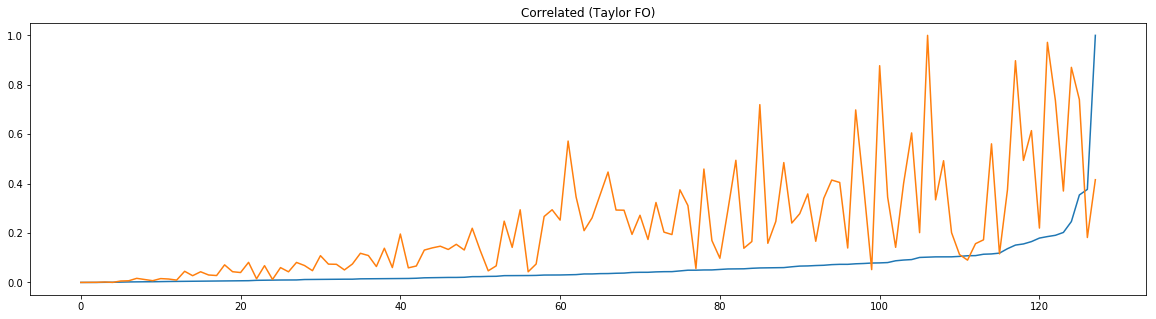

In [58]:
figure(figsize=(20,5))
s = imp_corr_bn.cpu().sort()[0].cpu().numpy()
order = imp_corr_bn.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Correlated (Taylor FO)")
loss_diff = (loss_mat_corr - loss_base_corr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

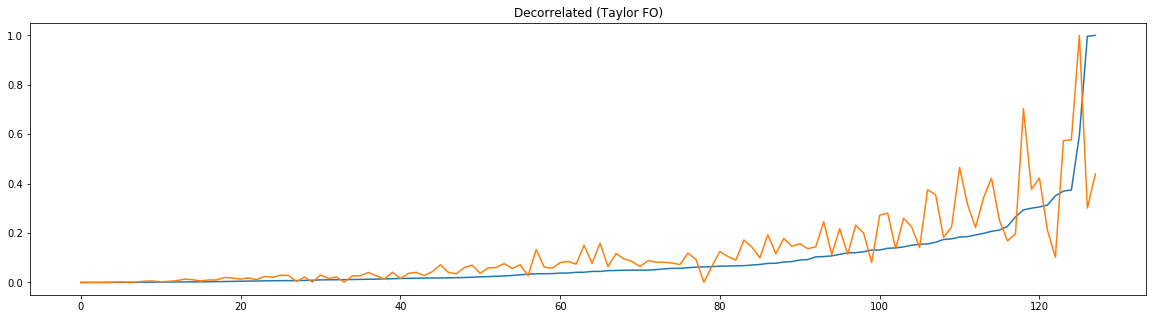

In [48]:
figure(figsize=(20,5))

s = imp_decorr_bn.cpu().sort()[0].cpu().numpy()
order = imp_decorr_bn.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Decorrelated (Taylor FO)")
loss_diff = (loss_mat_decorr - loss_base_decorr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

# 12

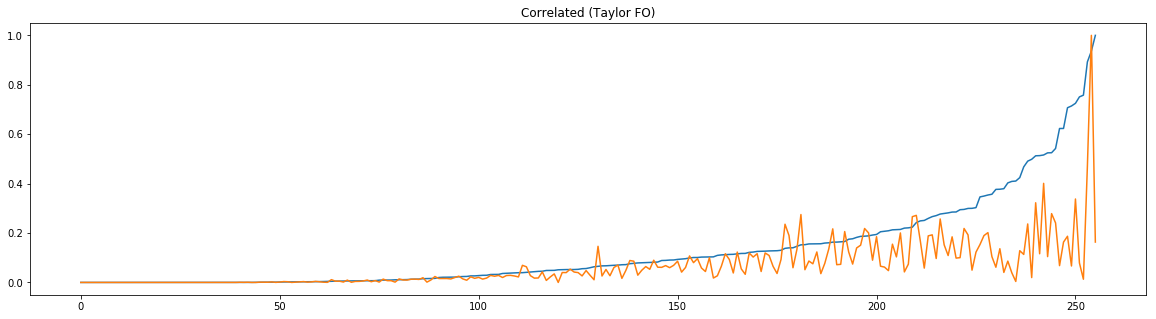

In [79]:
figure(figsize=(20,5))
s = imp_corr_bn.cpu().sort()[0].cpu().numpy()
order = imp_corr_bn.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Correlated (Taylor FO)")
loss_diff = (loss_mat_corr - loss_base_corr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

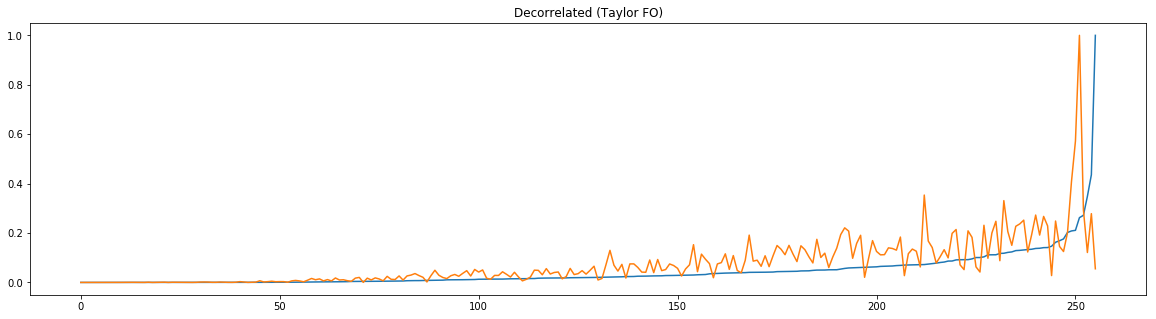

In [80]:
figure(figsize=(20,5))

s = imp_decorr_bn.cpu().sort()[0].cpu().numpy()
order = imp_decorr_bn.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Decorrelated (Taylor FO)")
loss_diff = (loss_mat_decorr - loss_base_decorr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

# Importance plots Netslim Train

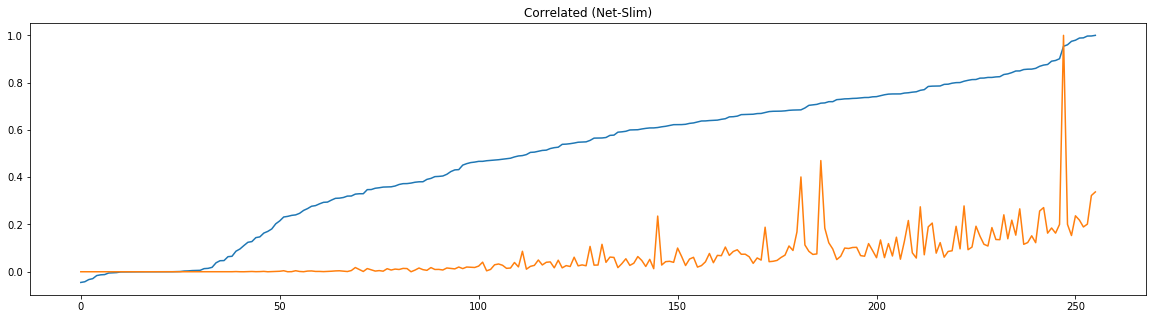

In [81]:
figure(figsize=(20,5))

s = scale_corr.cpu().sort()[0].cpu().numpy()
order = scale_corr.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Correlated (Net-Slim)")
loss_diff = (loss_mat_corr - loss_base_corr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

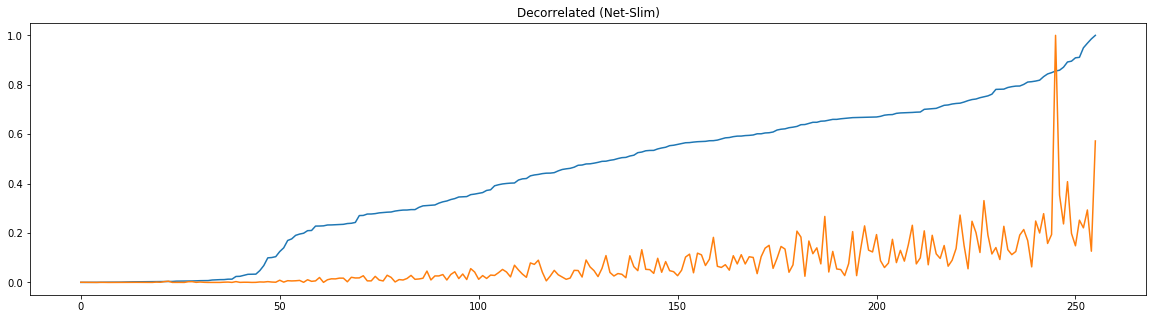

In [82]:
figure(figsize=(20,5))

s = scale_decorr.cpu().sort()[0].cpu().numpy()
order = scale_decorr.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Decorrelated (Net-Slim)")
loss_diff = (loss_mat_decorr - loss_base_decorr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

# Importance plots L2 train

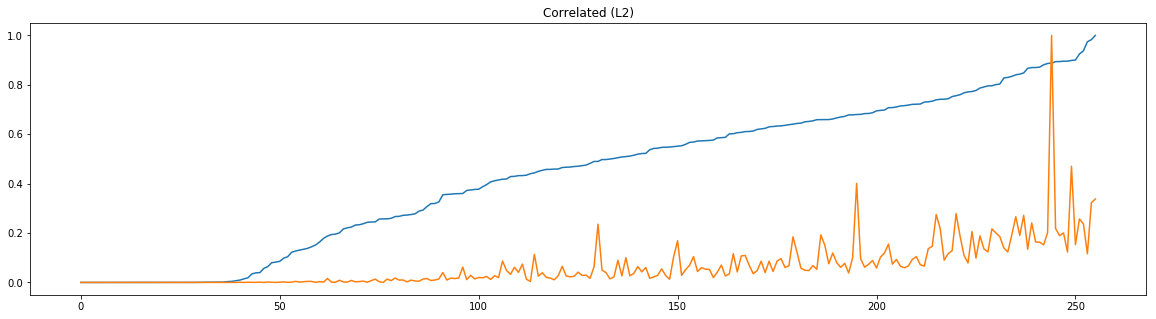

In [83]:
figure(figsize=(20,5))
s = w_imp_corr.sort()[0].cpu().numpy()
order = w_imp_corr.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Correlated (L2)")
loss_diff = (loss_mat_corr - loss_base_corr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

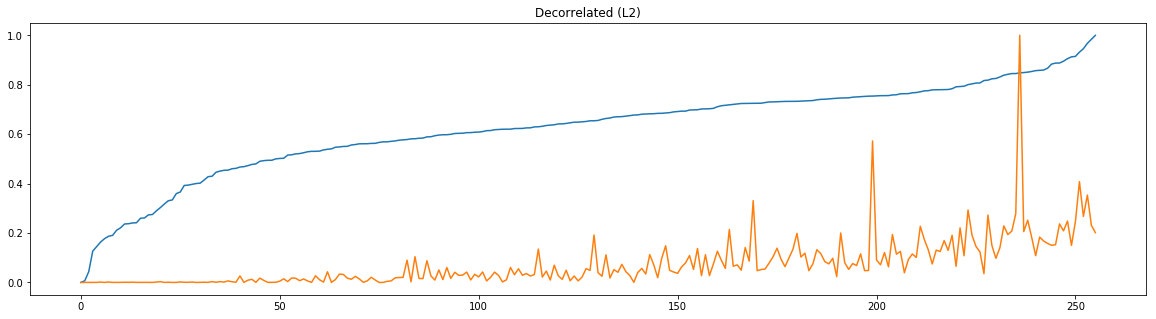

In [84]:
figure(figsize=(20,5))
s = w_imp_decorr.sort()[0].cpu().numpy()
order = w_imp_decorr.sort()[1].cpu().numpy()
plt.plot(s/s.max())
plt.title("Decorrelated (L2)")
loss_diff = (loss_mat_decorr - loss_base_decorr).abs()
plt.plot(loss_diff[order]/loss_diff.max())

# Train networks

# Inner product training

In [ ]:
net = VGG('VGG13').to(device)
# PATH = './cifar100_net.pth'
PATH = './w_decorr/base_params/wnet_base.pth'
net.load_state_dict(torch.load(PATH))

# net_d = VGG('VGG13').to(device)
# PATH_d = './w_decorr/wnet_all.pth'
# net_d.load_state_dict(torch.load(PATH_d))

In [ ]:
cal_acc(net.eval())

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [ ]:
l_temp = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net.features[layer_index-3].weight.shape
    
    l_temp.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*(c_out*c_in*w_f*h_f)**(1/4))
    
    
l_temp = np.array(l_temp)
l_temp = l_temp/l_temp.sum()

l_imp = {}
i = 0
for layer_index in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
    
    l_imp.update({layer_index : l_temp[i]})
    i+=1

In [ ]:
cal_acc(net.eval())

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    num_iter = 0
    angle_cost = 0.0
    for i, data in enumerate(trainloader, 0):
        num_iter += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        L_angle = 0
        for conv_ind in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
            w_mat = net.features[conv_ind].weight
            w_mat1 = (w_mat.reshape(w_mat.shape[0],-1))
            
            b_mat = net.features[conv_ind].bias
            b_mat1 = (b_mat.reshape(b_mat.shape[0],-1))
            
            params = torch.cat((w_mat1, b_mat1), dim=1)
            
            angle_mat = torch.matmul(params, torch.t(params)) - torch.eye(w_mat.shape[0]).to(device)
            
            L_angle += (l_imp[conv_ind])*(angle_mat).norm(1) #.norm().pow(2))
        
        Lc = criterion(outputs, labels)
        loss = (1e-1)*(L_angle) + Lc
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        angle_cost += (L_angle).item()
    
    print("angle_cost: ", angle_cost/num_iter)
#     print("diag_mass_ratio: ", (num_iter*(64+128+256+1024)*2)/(L_angle.detach().cpu().numpy()))
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / num_iter))
    running_loss = 0.0
    cal_acc(net.eval())
    
print('Finished Training')

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    num_iter = 0
    angle_cost = 0.0
    for i, data in enumerate(trainloader, 0):
        num_iter += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        L_angle = 0
        for conv_ind in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
            w_mat = net.features[conv_ind].weight
            w_mat1 = (w_mat.reshape(w_mat.shape[0],-1))
            
            b_mat = net.features[conv_ind].bias
            b_mat1 = (b_mat.reshape(b_mat.shape[0],-1))
            
            params = torch.cat((w_mat1, b_mat1), dim=1)
            
            angle_mat = torch.matmul(params, torch.t(params)) - torch.eye(w_mat.shape[0]).to(device)
            
            L_angle += (l_imp[conv_ind])*(angle_mat).norm(1) #.norm().pow(2))
        
        Lc = criterion(outputs, labels)
        loss = (1e-1)*(L_angle) + Lc
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        angle_cost += (L_angle).item()
    
    print("angle_cost: ", angle_cost/num_iter)
#     print("diag_mass_ratio: ", (num_iter*(64+128+256+1024)*2)/(L_angle.detach().cpu().numpy()))
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / num_iter))
    running_loss = 0.0
    cal_acc(net.eval())
    
print('Finished Training')

In [ ]:
L_diag = 0
L_angle = 0
for conv_ind in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
    w_mat = net.features[conv_ind].weight
    w_mat1 = (w_mat.reshape(w_mat.shape[0],-1))

    b_mat = net.features[conv_ind].bias
    b_mat1 = (b_mat.reshape(b_mat.shape[0],-1))

#     g_mat = net.features[conv_ind+2].weight
#     g_mat1 = (b_mat.reshape(b_mat.shape[0],-1))

#     be_mat = net.features[conv_ind+2].bias
#     be_mat1 = (b_mat.reshape(b_mat.shape[0],-1))

    params = torch.cat((w_mat1, b_mat1), dim=1)

    angle_mat = torch.matmul(params, torch.t(params))

    L_diag = (l_imp[conv_ind])*(angle_mat.diag().norm(1))
    L_angle = (l_imp[conv_ind])*(angle_mat.norm(1))
    
    print(L_diag.cpu()/L_angle.cpu())

In [ ]:
torch.matmul(w_mat1, w_mat1.t())

In [ ]:
cal_acc(net.eval()), cal_acc_train(net.eval())

In [ ]:
PATH = './w_decorr/wnet_eye_2.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
0, 3, 7, 10, 14, 17, 21, 24, 28, 31

In [ ]:
l = 14
w = net.features[l].weight.data.clone()

In [ ]:
plt.figure(figsize=(10,10))
w = w.reshape((w.shape[0], -1))
angle_mat = torch.matmul(w, w.t()).abs().cpu() 
plt.imshow(angle_mat)
plt.colorbar()

In [ ]:
w_d = net_d.features[l].weight.data.clone()

In [ ]:
plt.figure(figsize=(10,10))
w_d = w_d.reshape((w_d.shape[0], -1))
angle_mat_d = torch.matmul(w_d, w_d.t()).abs().cpu() 
plt.imshow(angle_mat_d)
plt.colorbar()

In [ ]:
u, s, v = np.linalg.svd(w.cpu().detach().numpy())

In [ ]:
plt.plot(s)
plt.xlabel("index")
plt.ylabel("sigma")
# plt.savefig("w_31.png")

In [ ]:
u_d, s_d, v_d = np.linalg.svd(w_d.cpu().detach().numpy())

In [ ]:
plt.plot(s_d)
plt.xlabel("index")
plt.ylabel("sigma")
# plt.savefig("w_d_31.png")